In [1]:
import cv2                                # state of the art computer vision algorithms library
import numpy as np                        # fundamental package for scientific computing
import matplotlib.pyplot as plt           # 2D plotting library producing publication quality figures
import pyrealsense2 as rs                 # Intel RealSense cross-platform open-source API
import seaborn as sns
print("Environment Ready")

Environment Ready


## The API
Next, we will open depth and RGB streams from pre-recorded file and capture a set of frames:


In [2]:
# Setup:
pipe = rs.pipeline()
cfg = rs.config()
cfg.enable_device_from_file("/home/dayananda/Documents/20230727_155611.bag")
profile = pipe.start(cfg)

# Skip 5 first frames to give the Auto-Exposure time to adjust
for x in range(5):
  pipe.wait_for_frames()
  
# Store next frameset for later processing:
frameset = pipe.wait_for_frames()
color_frame = frameset.get_color_frame()
depth_frame = frameset.get_depth_frame()

# Cleanup:
pipe.stop()
print("Frames Captured")

Frames Captured


## RGB Data
Let's start with accessing the color componnent of the frameset:

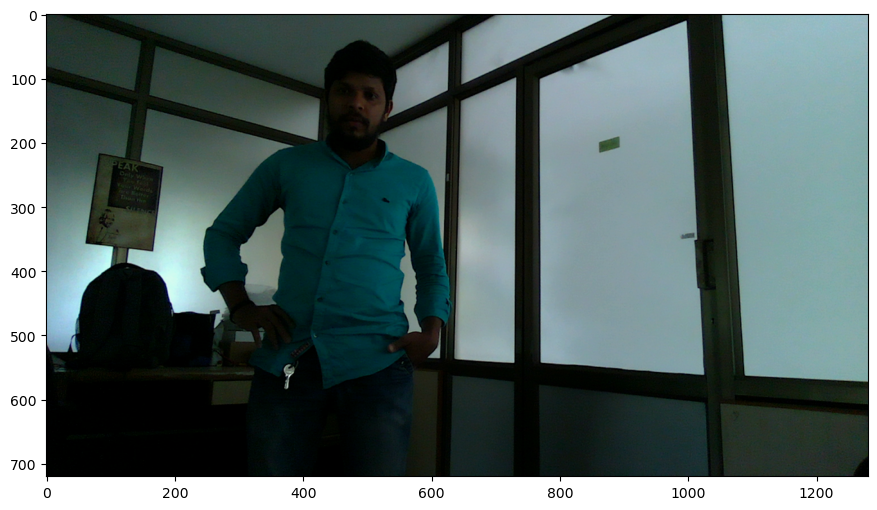

In [3]:
color = np.asanyarray(color_frame.get_data())
plt.rcParams["axes.grid"] = False
plt.rcParams['figure.figsize'] = [12, 6]
plt.imshow(color)

In [4]:
color

array([[[ 20,  40,  35],
        [ 26,  46,  41],
        [ 27,  46,  50],
        ...,
        [157, 182, 189],
        [159, 186, 199],
        [160, 187, 200]],

       [[ 24,  44,  41],
        [ 30,  50,  47],
        [ 31,  50,  52],
        ...,
        [158, 183, 190],
        [158, 185, 196],
        [160, 187, 198]],

       [[ 25,  44,  44],
        [ 32,  51,  51],
        [ 33,  51,  47],
        ...,
        [159, 187, 193],
        [158, 185, 194],
        [159, 186, 195]],

       ...,

       [[  0,   0,   0],
        [  1,   1,   1],
        [  0,   3,   2],
        ...,
        [  2,   2,   2],
        [  3,   2,   2],
        [  1,   0,   0]],

       [[  1,   1,   3],
        [  3,   3,   5],
        [  3,   3,   3],
        ...,
        [  1,   1,   1],
        [  2,   1,   1],
        [  1,   0,   0]],

       [[  1,   1,   1],
        [  1,   1,   1],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  2,   1,   1],
        [  2,   1,   1]]

## Depth Data
Now, we will visualize the depth map captured by the RealSense camera:

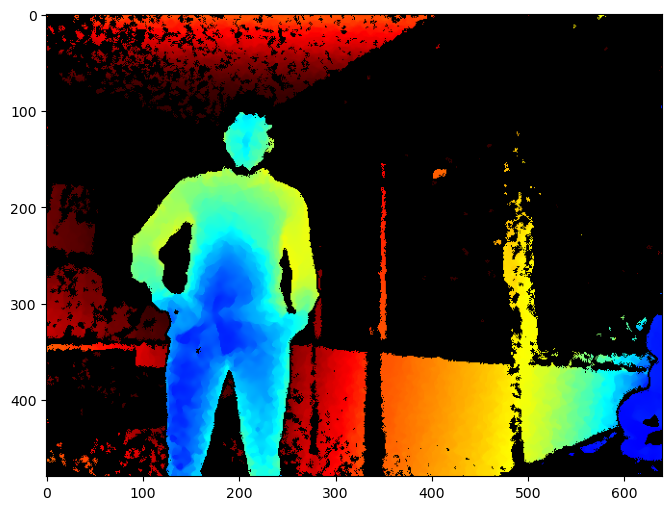

In [5]:
colorizer = rs.colorizer()
colorized_depth = np.asanyarray(colorizer.colorize(depth_frame).get_data())
plt.imshow(colorized_depth)

## Stream Alignment
Upon closer inspection you can notice that the two frames are not captured from the same physical viewport.

To combine them into a single RGBD image, let's align depth data to color viewport:

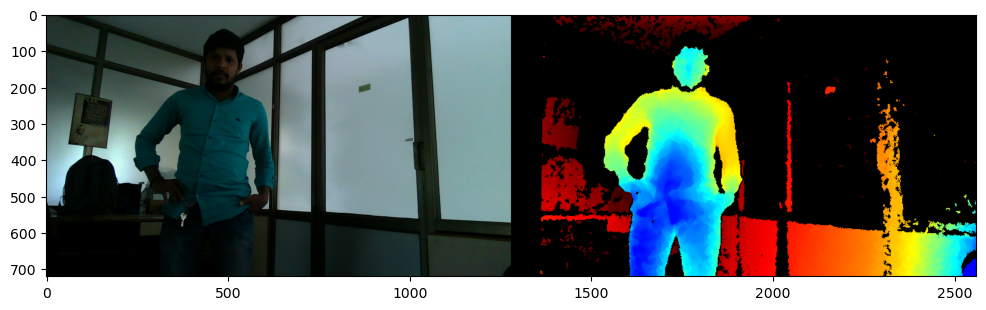

In [6]:
# Create alignment primitive with color as its target stream:
align = rs.align(rs.stream.color)
frameset = align.process(frameset)

# Update color and depth frames:
aligned_depth_frame = frameset.get_depth_frame()
colorized_depth = np.asanyarray(colorizer.colorize(aligned_depth_frame).get_data())

# Show the two frames together:
images = np.hstack((color, colorized_depth))
plt.imshow(images)

Now the two images are pixel-perfect aligned and you can use depth data just like you would any of the other channels.

## Object Detection

Next, we will take advantage of widely popular **MobileNet SSD Model** to recognize and localize objects in the scene and use additional depth data to enrich our prediction.

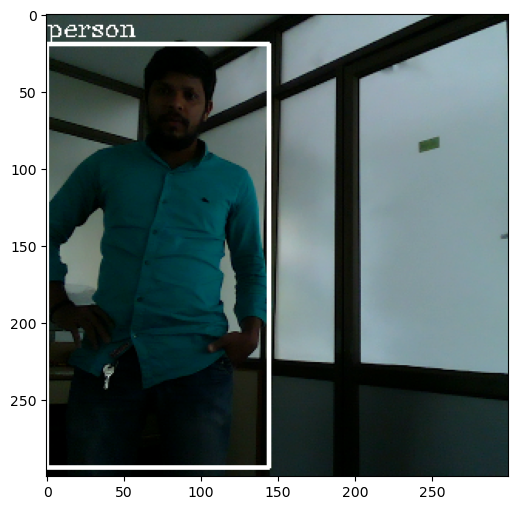

In [7]:
# Standard OpenCV boilerplate for running the net:
height, width = color.shape[:2]
expected = 300
aspect = width / height
resized_image = cv2.resize(color, (round(expected * aspect), expected))
crop_start = round(expected * (aspect - 1) / 2)
crop_img = resized_image[0:expected, crop_start:crop_start+expected]

net = cv2.dnn.readNetFromCaffe("deploy.prototxt", "mobilenet_iter_73000.caffemodel")
inScaleFactor = 0.007843
meanVal       = 127.53
classNames = ("background", "aeroplane", "bicycle", "bird", "boat",
              "bottle", "bus", "car", "cat", "chair",
              "cow", "diningtable", "dog", "horse",
              "motorbike", "person", "pottedplant",
              "sheep", "sofa", "train", "tvmonitor")

blob = cv2.dnn.blobFromImage(crop_img, inScaleFactor, (expected, expected), meanVal, False)
net.setInput(blob, "data")
detections = net.forward("detection_out")

label = detections[0,0,0,1]
conf  = detections[0,0,0,2]
xmin  = detections[0,0,0,3]
ymin  = detections[0,0,0,4]
xmax  = detections[0,0,0,5]
ymax  = detections[0,0,0,6]

className = classNames[int(label)]

cv2.rectangle(crop_img, (int(xmin * expected), int(ymin * expected)), 
             (int(xmax * expected), int(ymax * expected)), (255, 255, 255), 2)
cv2.putText(crop_img, className, 
            (int(xmin * expected), int(ymin * expected) - 5),
            cv2.FONT_HERSHEY_COMPLEX, 0.5, (255,255,255))

plt.imshow(crop_img)

In [8]:
print((int(xmin * expected),int(ymin * expected),int(xmax * expected),int(ymax * expected)))

(0, 19, 144, 294)


In [9]:
print(expected)

300


By projecting this data into the depth channel, we can now answer additional questions we couldn't approach before.

For example, with computer vision only it would be rather hard to make any meaningful predictions about **size and distance**.
You could train a model on average dog size per breed, but it would be easily fooled by toys of dogs or dogs of irregular proportions. Instead you can get this information directly when you have depth available!

Let's project our detected bounding box on to the depth image, and average the depth data inside it to get a sense of how close is the object:

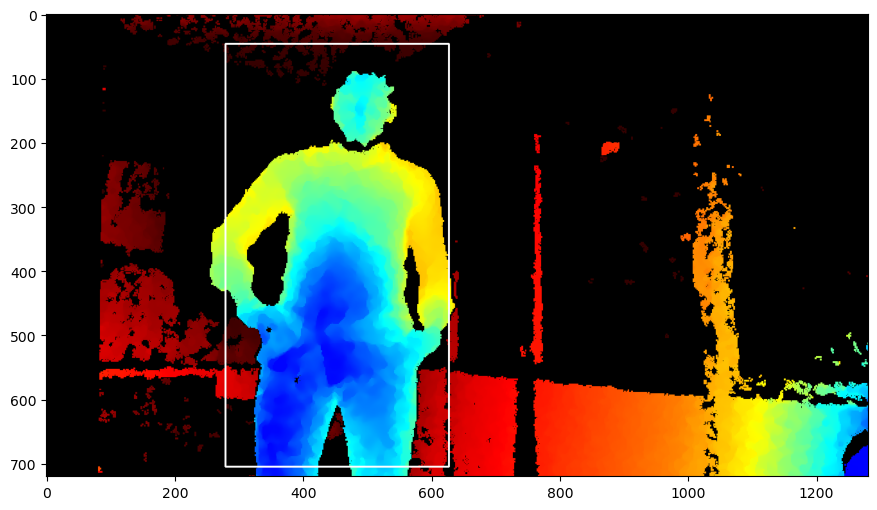

In [10]:
scale = height / expected
xmin_depth = int((xmin * expected + crop_start) * scale)
ymin_depth = int((ymin * expected) * scale)
xmax_depth = int((xmax * expected + crop_start) * scale)
ymax_depth = int((ymax * expected) * scale)
xmin_depth,ymin_depth,xmax_depth,ymax_depth
cv2.rectangle(colorized_depth, (xmin_depth, ymin_depth), 
             (xmax_depth, ymax_depth), (255, 255, 255), 2)
plt.imshow(colorized_depth)

In [11]:
print(xmin_depth,ymin_depth,xmax_depth,ymax_depth)

279 46 627 705


In [12]:
depth = np.asanyarray(aligned_depth_frame.get_data())
# Crop depth data:
depth = depth[xmin_depth:xmax_depth,ymin_depth:ymax_depth].astype(float)

# Get data scale from the device and convert to meters
depth_scale = profile.get_device().first_depth_sensor().get_depth_scale()
depth = depth * depth_scale
dist,_,_,_ = cv2.mean(depth)
print("Detected a {0} {1:.3} meters away.".format(className, dist))

Detected a person 1.12 meters away.


This is a rather simple example, but it gives you a taste of what can be accomplished by combining depth with modern computer vision.

> **Want to learn more?** Visit [realsense.intel.com](http://realsense.intel.com) and [github.com/IntelRealSense](http://www.github.com/IntelRealSense/librealsense)

In [13]:
import cv2
import numpy as np

# Function to calculate Intersection over Union (IoU)
def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    if xB < xA or yB < yA:
        return 0.0

    intersection_area = (xB - xA) * (yB - yA)
    boxA_area = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxB_area = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = intersection_area / float(boxA_area + boxB_area - intersection_area)
    return iou

# Assuming you have the ground truth bounding boxes in a list of tuples (xmin, ymin, xmax, ymax, class_name)
ground_truth_boxes = [
    (70, 60, 300, 300, className),
    # Add more ground truth boxes as needed
]

# Assuming you have the detected bounding boxes in a list of tuples (xmin_det, ymin_det, xmax_det, ymax_det, class_name)
detected_boxes = [
    (74, 73, 301, 301, className),
    # Add more detected boxes as needed
]

# Initialize variables to keep track of total IoU and total detections
total_iou = 0.0
total_detections = 0

# Loop through detected boxes and compare with ground truth
for det_box in detected_boxes:
    for gt_box in ground_truth_boxes:
        if det_box[4] == gt_box[4]:  # Check if class names match
            iou = calculate_iou(det_box[:4], gt_box[:4])
            if iou > 0.5:  # Consider a detection correct if IoU > 0.5
                total_iou += iou
                total_detections += 1
                break  # Move to the next detected box after finding a match

# Calculate mean IoU and detection accuracy
mean_iou = total_iou / total_detections if total_detections > 0 else 0.0
detection_accuracy = total_detections / len(detected_boxes) * 100

# Print the results
print("Mean IoU: {:.3f}".format(mean_iou))
print("Detection Accuracy: {:.2f}%".format(detection_accuracy))


Mean IoU: 0.922
Detection Accuracy: 100.00%


In [14]:
import cv2
import numpy as np

# Function to calculate Intersection over Union (IoU)
def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    if xB < xA or yB < yA:
        return 0.0

    intersection_area = (xB - xA) * (yB - yA)
    boxA_area = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxB_area = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = intersection_area / float(boxA_area + boxB_area - intersection_area)
    return iou

# Assuming you have the ground truth bounding boxes in a list of tuples (xmin, ymin, xmax, ymax, class_name)
ground_truth_boxes = [
    (0, 110, 65, 300, className),
    (70, 60, 300, 300, className),

    # Add more ground truth boxes as needed
]

# Assuming you have the detected bounding boxes in a list of tuples (xmin_det, ymin_det, xmax_det, ymax_det, class_name)
detected_boxes = [
    (0, 0, 0, 0, className),
    (74, 73, 301, 301, className),
    # Add more detected boxes as needed
]

# Initialize variables to keep track of total IoU and total detections
total_iou = 0.0
total_detections = 0

# Loop through detected boxes and compare with ground truth
for det_box in detected_boxes:
    for gt_box in ground_truth_boxes:
        if det_box[4] == gt_box[4]:  # Check if class names match
            iou = calculate_iou(det_box[:4], gt_box[:4])
            if iou > 0.5:  # Consider a detection correct if IoU > 0.5
                total_iou += iou
                total_detections += 1
                break  # Move to the next detected box after finding a match

# Calculate mean IoU and detection accuracy
mean_iou = total_iou / total_detections if total_detections > 0 else 0.0
detection_accuracy = total_detections / len(detected_boxes) * 100

# Print the results
print("Mean IoU: {:.3f}".format(mean_iou))
print("Detection Accuracy: {:.2f}%".format(detection_accuracy))


Mean IoU: 0.922
Detection Accuracy: 50.00%


Confusion Matrix:
[[4 1]
 [0 1]]


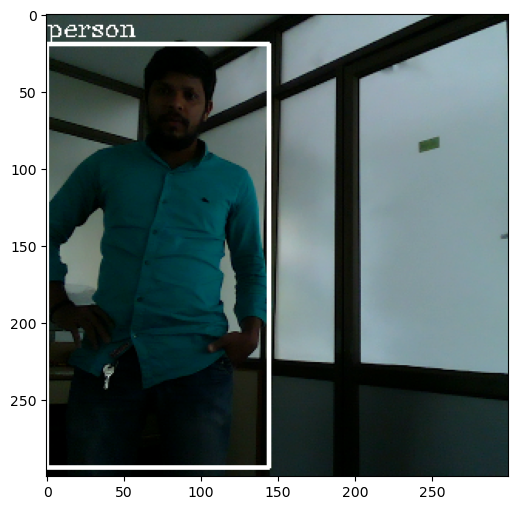

In [15]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


def calculate_iou(xmin1, ymin1, xmax1, ymax1, xmin2, ymin2, xmax2, ymax2):
    # Calculate the coordinates of the intersection rectangle
    x_left = max(xmin1, xmin2)
    y_top = max(ymin1, ymin2)
    x_right = min(xmax1, xmax2)
    y_bottom = min(ymax1, ymax2)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # Calculate the area of both bounding boxes
    box1_area = (xmax1 - xmin1) * (ymax1 - ymin1)
    box2_area = (xmax2 - xmin2) * (ymax2 - ymin2)

    # Calculate IoU
    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    return iou



# Load the ground truth data (you need to replace this with actual ground truth data)
# Each entry in the list contains a tuple (class_label, xmin, ymin, xmax, ymax)
ground_truth_data = [(className, 70, 60, 300, 300), ("not " + className, 0, 110, 65, 300,)]

# Standard OpenCV boilerplate code (your provided code)
# Standard OpenCV boilerplate for running the net:
height, width = color.shape[:2]
expected = 300
aspect = width / height
resized_image = cv2.resize(color, (round(expected * aspect), expected))
crop_start = round(expected * (aspect - 1) / 2)
crop_img = resized_image[0:expected, crop_start:crop_start+expected]

net = cv2.dnn.readNetFromCaffe("deploy.prototxt", "mobilenet_iter_73000.caffemodel")
inScaleFactor = 0.007843
meanVal       = 127.53
classNames = ("background", "aeroplane", "bicycle", "bird", "boat",
              "bottle", "bus", "car", "cat", "chair",
              "cow", "diningtable", "dog", "horse",
              "motorbike", "person", "pottedplant",
              "sheep", "sofa", "train", "tvmonitor")

blob = cv2.dnn.blobFromImage(crop_img, inScaleFactor, (expected, expected), meanVal, False)
net.setInput(blob, "data")
detections = net.forward("detection_out")

label = detections[0,0,0,1]
conf  = detections[0,0,0,2]
xmin  = detections[0,0,0,3]
ymin  = detections[0,0,0,4]
xmax  = detections[0,0,0,5]
ymax  = detections[0,0,0,6]

className = classNames[int(label)]

cv2.rectangle(crop_img, (int(xmin * expected), int(ymin * expected)), 
             (int(xmax * expected), int(ymax * expected)), (255, 255, 255), 2)
cv2.putText(crop_img, className, 
            (int(xmin * expected), int(ymin * expected) - 5),
            cv2.FONT_HERSHEY_COMPLEX, 0.5, (255,255,255))

plt.imshow(crop_img)

# Prepare the ground truth and predictions for the confusion matrix
true_labels = [className,70, 60, 300, 300]  # Ground truth class labels
predicted_labels = [className,74, 73, 301, 301]  # Predicted class labels

# Iterate through the detections and match with ground truth
for i in range(detections.shape[2]):
    confidence = detections[0, 0, i, 2]
    if confidence > 0.5:  # Consider detections with confidence above a threshold (e.g., 0.5)
        label = int(detections[0, 0, i, 1])
        predicted_labels.append(classNames[label])
        # Find the ground truth box with highest IoU for each predicted box
        max_iou = 0
        matched_gt_box = None
        for gt_label, gt_xmin, gt_ymin, gt_xmax, gt_ymax in ground_truth_data:
            iou = calculate_iou(gt_xmin, gt_ymin, gt_xmax, gt_ymax, xmin * expected, ymin * expected, xmax * expected, ymax * expected)
            if iou > max_iou:
                max_iou = iou
                matched_gt_box = gt_label
        if max_iou > 0.5:
            true_labels.append(matched_gt_box)
        else:
            true_labels.append("not " + className)  # If no significant overlap, consider it a negative

# Create the confusion matrix
confusion_matrix = np.zeros((2, 2), dtype=int)

for true_label, predicted_label in zip(true_labels, predicted_labels):
    if true_label == className:
        if predicted_label == className:
            confusion_matrix[1, 1] += 1  # True Positive
        else:
            confusion_matrix[1, 0] += 1  # False Negative
    else:
        if predicted_label == className:
            confusion_matrix[0, 1] += 1  # False Positive
        else:
            confusion_matrix[0, 0] += 1  # True Negative

print("Confusion Matrix:")
print(confusion_matrix)


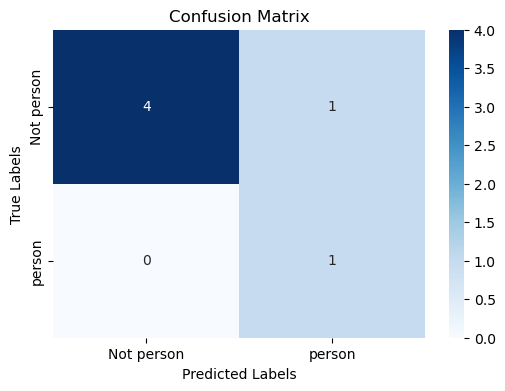

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix data
confusion_matrix = np.array([[4, 1], [0, 1]])

# Labels for the matrix
class_names = ["Not " + className,className]

# Create the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add labels, title, and axis ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=np.arange(2) + 0.5, labels=class_names)
plt.yticks(ticks=np.arange(2) + 0.5, labels=class_names)
plt.show()
